In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('csv',data_files='dataset_propositionattribution_nerfeatures.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","entity_map_ev","entities_ev","gem_exp","gem_label","gpt_label","gpt_exp","gold_exp","synonym","voice","split"],skiprows=1)

Using custom data configuration default-022bc67e9c58e92d
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 192.59it/s]


In [3]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-2b8e361375c0e153.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-0cc9bb699c2761fb.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-608a44ac65076739.arrow


In [4]:
columns_to_keep = ["claim", "premise", "label", "category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 465
    })
    test: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
        num_rows: 234
    })
})

In [6]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)

# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-09e6c9d5e8174284.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-92dc2d7bd9b3606b.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-9085af503aa35035.arrow


Label Encoding Mapping: {'contradiction': 0, 'entailment': 1, 'neutral': 2}


In [7]:
labels = np.array(dataset['train']['label'])

In [8]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='pritamdeka/PubMedBERT-MNLI-MedNLI'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts
        claim = item['claim'] 
        evidences = item['premise']
        item['premise']=evidences
        item['claim']=claim
        additional_features = [
            "count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
    
        for feature in additional_features:
            if feature in item:
                claim += "[SEP]" + str(item[feature])
        # Tokenize the texts
        inputs = self.tokenizer(
            evidences,claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
         # Construct the output item
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': evidences  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item



In [9]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [10]:
model_name = "pritamdeka/PubMedBERT-MNLI-MedNLI"
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1}

In [12]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
    num_rows: 1623
})

In [13]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [14]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [15]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [16]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [17]:
tdata.__getitem__(0)

{'input_ids': tensor([    2,  1920,  4415, 16984,  1927, 14542,  4006,  4480,  1930, 14227,
          5004,  2760,  1920, 29555,  1927,  1920,  4486, 14269,  1922,  1920,
         25420,  1930,  3185,  1920,  3238,  1954,  1930, 10472,  3170,  1942,
          2760,  1920,  8828,  1927,  1920,  4407,  1930,  3714,  1920,  7104,
          2495,    18,     3, 14227,  5004,  4415,  6691,  1977,  8929,  2251,
          1922,  4407,  5715,  4461,  1942,  4087,  3326,  1920,  7818,  1927,
          1920,  4407,    18,     3,    20,     3,    20,     3,    20,     3,
            20,     3,    20,     3,    20,     3,    20,     3,    20,     3,
            20,     3,    20,     3,    20,     3,    20,     3,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [18]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/1.4.3_pubmedbert/',
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.1,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/1.4.3_pubmedbert/best_model')
tokenizer.save_pretrained(f'/home/elson/1.4.3_pubmedbert/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1020


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.838300,0.827092,0.643011,0.639047,0.643011,0.640917
2,0.674900,0.956239,0.559140,0.673916,0.559140,0.587575
3,0.440900,1.156332,0.625806,0.616533,0.625806,0.615732
4,0.225500,1.285227,0.610753,0.674748,0.610753,0.632521
5,0.293500,1.119357,0.651613,0.668195,0.651613,0.658967
6,0.239600,1.490329,0.612903,0.666013,0.612903,0.631434
7,0.092700,1.762197,0.645161,0.669365,0.645161,0.653105
8,0.129500,1.639976,0.660215,0.635758,0.660215,0.645145
9,0.050800,2.132267,0.632258,0.635022,0.632258,0.628736
10,0.022800,2.130069,0.645161,0.654300,0.645161,0.647173


***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/1.4.3_pubmedbert/checkpoint-51
Configuration saved in /home/elson/1.4.3_pubmedbert/checkpoint-51/config.json
Model weights saved in /home/elson/1.4.3_pubmedbert/checkpoint-51/pytorch_model.bin
Deleting older checkpoint [/home/elson/1.4.3_pubmedbert/checkpoint-510] due to args.save_total_limit
Deleting older checkpoint [/home/elson/1.4.3_pubmedbert/checkpoint-1530] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/1.4.3_pubmedbert/checkpoint-102
Configuration saved in /home/elson/1.4.3_pubmedbert/checkpoint-102/config.json
Model weights saved in /home/elson/1.4.3_pubmedbert/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32
Saving model checkpoint to /home/elson/1.4.3_pubmedbert/checkpoint-153
Configuration saved in /home/elson/1.4.3_pubmedbe

Loading best model from /home/elson/1.4.3_pubmedbert/checkpoint-612 (score: 0.6666666666666666).
***** Running Evaluation *****
  Num examples = 465
  Batch size = 32


Configuration saved in /home/elson/1.4.3_pubmedbert/best_model/config.json
Model weights saved in /home/elson/1.4.3_pubmedbert/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/1.4.3_pubmedbert/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/1.4.3_pubmedbert/best_model/special_tokens_map.json


('/home/elson/1.4.3_pubmedbert/best_model/tokenizer_config.json',
 '/home/elson/1.4.3_pubmedbert/best_model/special_tokens_map.json',
 '/home/elson/1.4.3_pubmedbert/best_model/vocab.txt',
 '/home/elson/1.4.3_pubmedbert/best_model/added_tokens.json',
 '/home/elson/1.4.3_pubmedbert/best_model/tokenizer.json')

In [19]:
model_path = "/home/elson/1.4.3_pubmedbert/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/1.4.3_pubmedbert/best_model/config.json
Model config BertConfig {
  "_name_or_path": "/home/elson/1.4.3_pubmedbert/best_model/",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "contradiction",
    "1": "entailment",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 0,
    "entailment": 1,
    "neutral": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading w

In [20]:
print(test_results)

PredictionOutput(predictions=array([[-3.375  ,  3.262  , -1.203  ],
       [-4.2    ,  5.766  , -2.863  ],
       [-2.72   ,  4.766  , -3.52   ],
       [ 5.355  , -1.795  , -2.84   ],
       [-3.424  ,  5.69   , -3.543  ],
       [-3.531  ,  5.848  , -3.451  ],
       [-3.96   ,  5.8    , -3.162  ],
       [-5.34   ,  4.637  , -0.709  ],
       [-4.54   ,  4.953  , -1.987  ],
       [-2.562  ,  5.11   , -3.941  ],
       [ 2.57   , -0.9756 , -1.1875 ],
       [-3.873  ,  5.87   , -3.184  ],
       [-4.19   ,  5.46   , -2.613  ],
       [-3.99   ,  5.836  , -3.076  ],
       [-4.145  ,  5.74   , -2.973  ],
       [ 1.437  ,  2.46   , -4.465  ],
       [-3.8    ,  5.883  , -3.354  ],
       [-3.785  ,  5.87   , -3.35   ],
       [-3.773  ,  5.598  , -3.197  ],
       [-3.883  ,  5.527  , -3.104  ],
       [-4.156  ,  5.41   , -2.754  ],
       [ 0.7607 ,  2.543  , -4.25   ],
       [-3.697  ,  5.72   , -3.426  ],
       [ 4.54   , -0.01602, -4.49   ],
       [ 6.223  , -1.949  , -3.287 

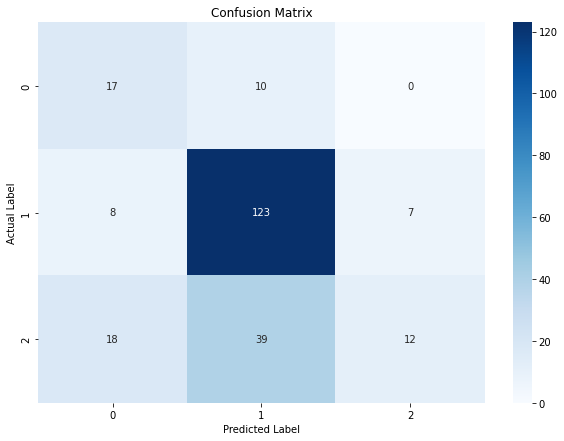

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [22]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/1.4.3_results.csv', index=False)

In [23]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [24]:
correct_classification_counts

General Health           39
Bone health              15
Diabetes                 12
Fitness                  12
Skin                     10
Cardiovascular Health     9
Cancer                    9
Throat                    7
Ear                       6
COVID                     5
Neurological health       5
Men's health              4
Women' s Health           4
Eye                       4
Blood                     4
Hair                      3
Mental Health             3
Muscles                   1
Name: Category, dtype: int64

In [25]:
misclassification_counts

Skin                     14
General Health           12
Hair                      9
Bone health               6
Eye                       5
Blood                     5
Muscles                   5
Neurological health       4
Vascular                  3
Dental Health             3
Fitness                   3
Cardiovascular Health     3
Cancer                    3
Women' s Health           2
Men's health              2
Throat                    2
COVID                     1
Name: Category, dtype: int64